In [1]:
# =============================
# Imports gerais
# =============================
import os
import math
import warnings
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error
)
from sklearn.model_selection import (
    KFold,
    RepeatedKFold
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import uniform, randint

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold, cross_val_score

from joblib import Parallel, delayed

warnings.filterwarnings("ignore")
np.random.seed(42)


In [2]:
# Funções utilitárias

def safe_log(y):
    return np.sign(y) * np.log1p(np.abs(y))

def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))

In [3]:
# Carregar dataset

print("Loading dataset...")

shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'

try:
    df = gpd.read_file(shp_path)
    print("Dataset loaded")
except Exception as e:
    raise RuntimeError(f"Error loading dataset: {e}")


Loading dataset...
Dataset loaded


In [4]:
# Remover NaN no target
n_before = len(df)
df = df.dropna(subset=['ros_p'])
n_after = len(df)
print(f"Removed {n_before - n_after} rows with NaN in 'ros_p'")

Removed 0 rows with NaN in 'ros_p'


In [5]:
# Target
y_raw = df['ros_p']
y = safe_log(y_raw)

# Criar versões log-transformadas
df_log = df.copy()
log_features = []

base_features = [c for c in df.columns if c not in ('ros_p', 'geometry')]
numeric_cols = df[base_features].select_dtypes(include=['number']).columns.tolist()

for col in numeric_cols:
    log_col = f"{col}_log"
    df_log[log_col] = safe_log(df_log[col])
    log_features.append(log_col)

# Features específicas
selected_features = ["wv10_kh_av_log", "dfmc_av", "FFMC_12h_a"]

# Criar matriz final de treino
X = df_log[selected_features]

print(f"N amostras: {len(y)}")
print(f"N features selecionadas: {len(selected_features)}")

N amostras: 851
N features selecionadas: 3


In [6]:
# Pré-processamento para features numéricas
numeric_cols = X.columns.tolist()

preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline completo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

# Cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=4, random_state=42)

# Avaliação
r2_scores = cross_val_score(pipeline, X, y, cv=rkf, scoring='r2', n_jobs=-1)
print(f"Mean CV R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

Mean CV R²: 0.1927 ± 0.0505


In [7]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# ============================================================
# AVALIAÇÃO COM REPEATED K-FOLD
# ============================================================

r2_train, r2_test, r2_gap = [], [], []

r2_log, mae_log, rmse_log = [], [], []
mae_lin, rmse_lin = [], []

for train_idx, test_idx in rkf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # IMPORTANTE:
    # best_model já é um Pipeline (preprocessador + Ridge)
    model = pipeline
    model.fit(X_train, y_train)

    # Previsões
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # ========================================================
    # R² train / test / gap
    # ========================================================
    r2_tr = r2_score(y_train, y_train_pred)
    r2_te = r2_score(y_test, y_test_pred)

    r2_train.append(r2_tr)
    r2_test.append(r2_te)
    r2_gap.append(r2_tr - r2_te)

    # ========================================================
    # MÉTRICAS NO ESPAÇO LOG
    # ========================================================
    r2_log.append(r2_te)
    mae_log.append(mean_absolute_error(y_test, y_test_pred))
    rmse_log.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    # ========================================================
    # MÉTRICAS NO ESPAÇO LINEAR
    # ========================================================
    y_test_lin = inverse_safe_log(y_test)
    y_pred_lin = inverse_safe_log(y_test_pred)

    mae_lin.append(mean_absolute_error(y_test_lin, y_pred_lin))
    rmse_lin.append(np.sqrt(mean_squared_error(y_test_lin, y_pred_lin)))

# ============================================================
# RESULTADOS
# ============================================================

print("=== R² ===")
print(f"Train: {np.mean(r2_train):.4f} ± {np.std(r2_train):.4f}")
print(f"Test:  {np.mean(r2_test):.4f} ± {np.std(r2_test):.4f}")
print(f"Gap:   {np.mean(r2_gap):.4f} ± {np.std(r2_gap):.4f}")

print("\n=== LOG ===")
print(f"R²:   {np.mean(r2_log):.4f} ± {np.std(r2_log):.4f}")
print(f"MAE:  {np.mean(mae_log):.4f} ± {np.std(mae_log):.4f} m/h")
print(f"RMSE: {np.mean(rmse_log):.4f} ± {np.std(rmse_log):.4f} m/h")

print("\n=== LINEAR ===")
print(f"MAE:  {np.mean(mae_lin):.2f} ± {np.std(mae_lin):.2f} m/h")
print(f"RMSE: {np.mean(rmse_lin):.2f} ± {np.std(rmse_lin):.2f} m/h")

=== R² ===
Train: 0.2067 ± 0.0124
Test:  0.1927 ± 0.0505
Gap:   0.0141 ± 0.0628

=== LOG ===
R²:   0.1927 ± 0.0505
MAE:  0.7450 ± 0.0336 m/h
RMSE: 0.9350 ± 0.0420 m/h

=== LINEAR ===
MAE:  496.96 ± 37.25 m/h
RMSE: 838.91 ± 98.40 m/h


In [8]:
# ============================================================
# TREINO FINAL COM TODOS OS DADOS 
# ============================================================

# Treinar pipeline completo
final_pipeline = pipeline.fit(X, y)

# Extrair apenas o modelo linear treinado
final_model = final_pipeline.named_steps["regressor"]

# Extrair pré-processador (para nomes das features)
preprocessor = final_pipeline.named_steps["preprocessor"]

# Nomes das features (somente numéricas, já que não há categóricas)
feature_names = X.columns.tolist()

# Guardar coeficientes em variáveis
final_coef = final_model.coef_
final_intercept = final_model.intercept_

# DataFrame auxiliar (opcional, só para inspeção)
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": final_coef,
    "importance": np.abs(final_coef)
}).sort_values("importance", ascending=False)

print("✅ Modelo final treinado.")
print(f"Nº de coeficientes: {len(final_coef)}")


✅ Modelo final treinado.
Nº de coeficientes: 3


In [9]:
# ============================================================
# CROSS-VALIDATION COM TODAS AS FEATURES
# ============================================================

# Pré-alocação de predições log
y_pred_log = np.zeros(len(y))

# Métricas temporárias
r2_train, r2_test = [], []
mae_log, rmse_log = [], []
mae_lin, rmse_lin = [], []

for tr, te in rkf.split(X):
    final_pipeline.fit(X.iloc[tr], y.iloc[tr])
    y_train_pred = final_pipeline.predict(X.iloc[tr])
    y_test_pred = final_pipeline.predict(X.iloc[te])

    y_pred_log[te] = y_test_pred

    # R²
    r2_train.append(r2_score(y.iloc[tr], y_train_pred))
    r2_test.append(r2_score(y.iloc[te], y_test_pred))

    # LOG
    mae_log.append(mean_absolute_error(y.iloc[te], y_test_pred))
    rmse_log.append(np.sqrt(mean_squared_error(y.iloc[te], y_test_pred)))

    # LINEAR
    y_te_lin = inverse_safe_log(y.iloc[te])
    y_pred_lin = inverse_safe_log(y_test_pred)
    mae_lin.append(mean_absolute_error(y_te_lin, y_pred_lin))
    rmse_lin.append(np.sqrt(mean_squared_error(y_te_lin, y_pred_lin)))

# Armazenar resultados
metrics_dict = {
    "r2_train_mean": np.mean(r2_train),
    "r2_train_std": np.std(r2_train),
    "r2_test_mean": np.mean(r2_test),
    "r2_test_std": np.std(r2_test),
    "r2_gap_mean": np.mean(r2_train) - np.mean(r2_test),
    "r2_gap_std": np.std(np.array(r2_train) - np.array(r2_test)),
    "mae_log_mean": np.mean(mae_log),
    "mae_log_std": np.std(mae_log),
    "rmse_log_mean": np.mean(rmse_log),
    "rmse_log_std": np.std(rmse_log),
    "mae_lin_mean": np.mean(mae_lin),
    "mae_lin_std": np.std(mae_lin),
    "rmse_lin_mean": np.mean(rmse_lin),
    "rmse_lin_std": np.std(rmse_lin),
}

# Guardar predições log
pred_log_dict = y_pred_log

print("✅ Avaliação final com todas as features concluída.")
print(f"R² médio teste: {metrics_dict['r2_test_mean']:.4f} ± {metrics_dict['r2_test_std']:.4f}")
print(f"MAE linear médio: {metrics_dict['mae_lin_mean']:.4f} ± {metrics_dict['mae_lin_std']:.4f} m/h")

✅ Avaliação final com todas as features concluída.
R² médio teste: 0.1927 ± 0.0505
MAE linear médio: 496.9599 ± 37.2500 m/h


In [10]:
import pickle

# ============================
# Treinar pipeline final com todas as features
# ============================
final_pipeline = pipeline.fit(X, y)

# ============================
# Salvar pipeline final
# ============================
model_path = "../../Data/Models/model_benchmark.pkl"
with open(model_path, "wb") as f:
    pickle.dump(final_pipeline, f)

print(f"✅ Pipeline final treinado e salvo em {model_path}")


✅ Pipeline final treinado e salvo em ../../Data/Models/model_benchmark.pkl


In [11]:
m = metrics_dict

print(f"=== Desempenho final ({1} features) ===")
print(f"R² treino: {m['r2_train_mean']:.4f} ± {m['r2_train_std']:.4f}")
print(f"R² teste : {m['r2_test_mean']:.4f} ± {m['r2_test_std']:.4f}")
print(f"R² gap   : {m['r2_gap_mean']:.4f} ± {m['r2_gap_std']:.4f}\n")

print("=== LOG ===")
print(f"MAE  : {m['mae_log_mean']:.4f} m/h ± {m['mae_log_std']:.4f} m/h")
print(f"RMSE : {m['rmse_log_mean']:.4f} m/h ± {m['rmse_log_std']:.4f} m/h\n")

print("=== LINEAR ===")
print(f"MAE  : {m['mae_lin_mean']:.2f} m/h ± {m['mae_lin_std']:.2f} m/h")
print(f"RMSE : {m['rmse_lin_mean']:.2f} m/h ± {m['rmse_lin_std']:.2f} m/h")


=== Desempenho final (1 features) ===
R² treino: 0.2067 ± 0.0124
R² teste : 0.1927 ± 0.0505
R² gap   : 0.0141 ± 0.0628

=== LOG ===
MAE  : 0.7450 m/h ± 0.0336 m/h
RMSE : 0.9350 m/h ± 0.0420 m/h

=== LINEAR ===
MAE  : 496.96 m/h ± 37.25 m/h
RMSE : 838.91 m/h ± 98.40 m/h


In [12]:
# ==============================
# Coeficientes do modelo Ridge
# ==============================

# Nomes das features (todas numéricas)
feature_names = X.columns.tolist()

# Extrair modelo Ridge
ridge_model = final_pipeline.named_steps['regressor']
coefs = ridge_model.coef_
intercept = ridge_model.intercept_

# ==============================
# Equação da regressão
# ==============================
print("\n=== Equação da regressão Ridge ===")
equation_terms = [f"{coef:.4f}*{name}" for coef, name in zip(coefs, feature_names)]
equation = " + ".join(equation_terms)
equation = f"y = {intercept:.4f} + " + equation
print(equation)



=== Equação da regressão Ridge ===
y = 6.2086 + 0.2694*wv10_kh_av_log + -0.3578*dfmc_av + -0.0727*FFMC_12h_a


In [13]:
# =============================
# SHAP + Predições médias + Merge com GeoDataFrame
# =============================

# Predições CV-safe
avg_pred_log = pred_log_dict          # predição log
avg_pred_linear = inverse_safe_log(avg_pred_log)  # predição linear

# Valores reais
avg_actual_log = y.values
avg_actual_linear = inverse_safe_log(y.values).round(6)

# -----------------------------
# Carregar shapefile e selecionar apenas observações do df
# -----------------------------
gdf = gpd.read_file(shp_path).reset_index(drop=True)
gdf_valid = gdf.loc[df.index].reset_index(drop=True)

# -----------------------------
# Criar DataFrame de resultados
# -----------------------------
shap_results = pd.DataFrame({
    'ros_p_log': avg_actual_log,
    'ros_p_linear': avg_actual_linear,
    'PredROS_log': avg_pred_log,
    'PredROS_linear': avg_pred_linear,
})

# Erros e flags
shap_results['PredDiff'] = shap_results['PredROS_linear'] - shap_results['ros_p_linear']
shap_results['Err_pct'] = (shap_results['PredDiff'] / shap_results['ros_p_linear']) * 100
shap_results['Error_p_abs'] = shap_results['Err_pct'].abs()
shap_results['bad_pred'] = shap_results['Error_p_abs'] > 35


In [14]:
import shap
import geopandas as gpd

# ==============================
# SHAP values para o modelo final
# ==============================

# nomes das features transformadas (apenas numéricas)
feature_names_transformed = X.columns.tolist()
feature_names_transformed = [name.split('__')[-1] for name in feature_names_transformed]


# Transformar X com o pré-processador do pipeline final
X_transformed = final_pipeline.named_steps['preprocessor'].transform(X)

# Explainer SHAP
explainer = shap.LinearExplainer(
    final_pipeline.named_steps['regressor'],
    X_transformed,
    feature_perturbation="interventional"
)

# Valores SHAP
shap_values = explainer.shap_values(X_transformed)

# DataFrame com nomes corretos
shap_values_df = pd.DataFrame(
    shap_values,
    columns=feature_names_transformed,
    index=X.index
).add_prefix("shap_")  # prefixo para evitar colisões

# ==============================
# Merge com GeoDataFrame
# ==============================
shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_short.shp'
gdf_final = gpd.read_file(shp_path)

merged_gdf = gpd.GeoDataFrame(
    pd.concat([
        gdf_final.reset_index(drop=True),
        df_log[log_features].reset_index(drop=True),
        shap_results.reset_index(drop=True),
        shap_values_df.reset_index(drop=True)
    ], axis=1),
    geometry='geometry',
    crs=gdf_final.crs
)


In [15]:
# -----------------------------
# Export
# -----------------------------
output_base = "../../Data/Models/PT_FireProg_model_SHAP_benchmark"

merged_gdf.to_file(f"{output_base}.shp")
merged_gdf.drop(columns='geometry').to_csv(f"{output_base}.csv", index=False)

print("✓ SHP e CSV exportados com sucesso")

✓ SHP e CSV exportados com sucesso


## PLOTS

In [16]:
# Extrair métricas do dicionário
metrics = metrics_dict

r2_train_cv = metrics["r2_train_mean"]
r2_train_std = metrics["r2_train_std"]
r2_test_cv = metrics["r2_test_mean"]
r2_test_std = metrics["r2_test_std"]
r2_gap_cv = metrics["r2_gap_mean"]
r2_gap_std = metrics["r2_gap_std"]

mae_cv_mean = metrics["mae_log_mean"]
mae_cv_std = metrics["mae_log_std"]
rmse_cv_mean = metrics["rmse_log_mean"]
rmse_cv_std = metrics["rmse_log_std"]

mae_linear_mean = metrics["mae_lin_mean"]
mae_linear_std = metrics["mae_lin_std"]
rmse_linear_mean = metrics["rmse_lin_mean"]
rmse_linear_std = metrics["rmse_lin_std"]

# Predições log CV-safe para n_features
y_pred_all = pred_log_dict
y_actual_all = y

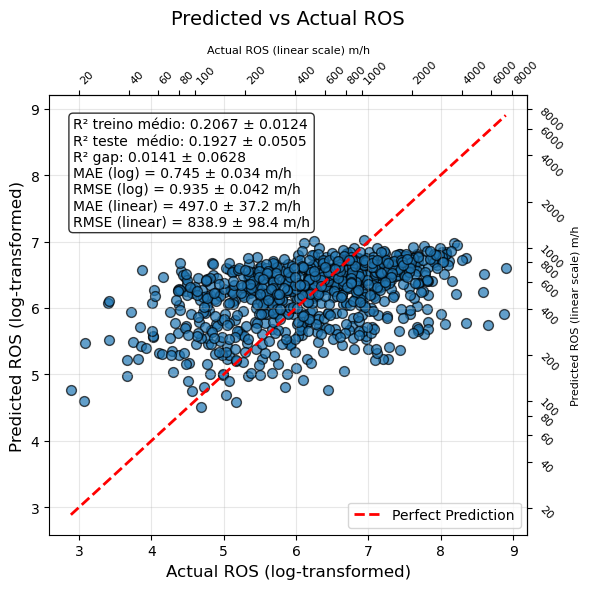

In [17]:
# =============================
# Scatter Plot com ± std
# =============================
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(y_actual_all, y_pred_all, alpha=0.7, edgecolor='k', s=50)

min_val = min(y_actual_all.min(), y_pred_all.min() - 1)
max_val = max(y_actual_all.max(), y_pred_all.max() + 1)
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_title('Predicted vs Actual ROS', fontsize=14, pad=15)
ax.set_xlabel('Actual ROS (log-transformed)', fontsize=12)
ax.set_ylabel('Predicted ROS (log-transformed)', fontsize=12)

ax.text(
    0.05, 0.95,
    f"R² treino médio: {r2_train_cv:.4f} ± {r2_train_std:.4f}\n"
    f"R² teste  médio: {r2_test_cv:.4f} ± {r2_test_std:.4f}\n"
    f"R² gap: {r2_gap_cv:.4f} ± {r2_gap_std:.4f}\n"
    f'MAE (log) = {mae_cv_mean:.3f} ± {mae_cv_std:.3f} m/h\n'
    f'RMSE (log) = {rmse_cv_mean:.3f} ± {rmse_cv_std:.3f} m/h\n'
    f'MAE (linear) = {mae_linear_mean:.1f} ± {mae_linear_std:.1f} m/h\n'
    f'RMSE (linear) = {rmse_linear_mean:.1f} ± {rmse_linear_std:.1f} m/h',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# =============================
# Eixos secundários (linear scale)
# =============================
def log_to_linear(x):
    return np.exp(x)

def linear_to_log(x):
    # Evita log(0)
    x_safe = np.where(x <= 0, 1e-6, x)
    return np.log(x_safe)

# Eixo superior (x) e direito (y)
ax_top = ax.secondary_xaxis('top', functions=(log_to_linear, linear_to_log))
ax_right = ax.secondary_yaxis('right', functions=(log_to_linear, linear_to_log))

# Ticks escalonados conforme seu exemplo
ticks_linear = list(range(0, 101, 20))        # 0,20,40,60,80,100
ticks_linear += list(range(200, 1001, 200))   # 200,400,...,1000
ticks_linear += list(range(2000, 10001, 2000))# 2000,4000,...,10000

ax_top.set_xticks(ticks_linear)
ax_right.set_yticks(ticks_linear)
plt.setp(ax_right.get_yticklabels(), rotation=315, ha='left', fontsize=8)
plt.setp(ax_top.get_xticklabels(), rotation=45, ha='left', fontsize=8)

ax_top.set_xlabel("Actual ROS (linear scale) m/h", fontsize=8)
ax_right.set_ylabel("Predicted ROS (linear scale) m/h", fontsize=8)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

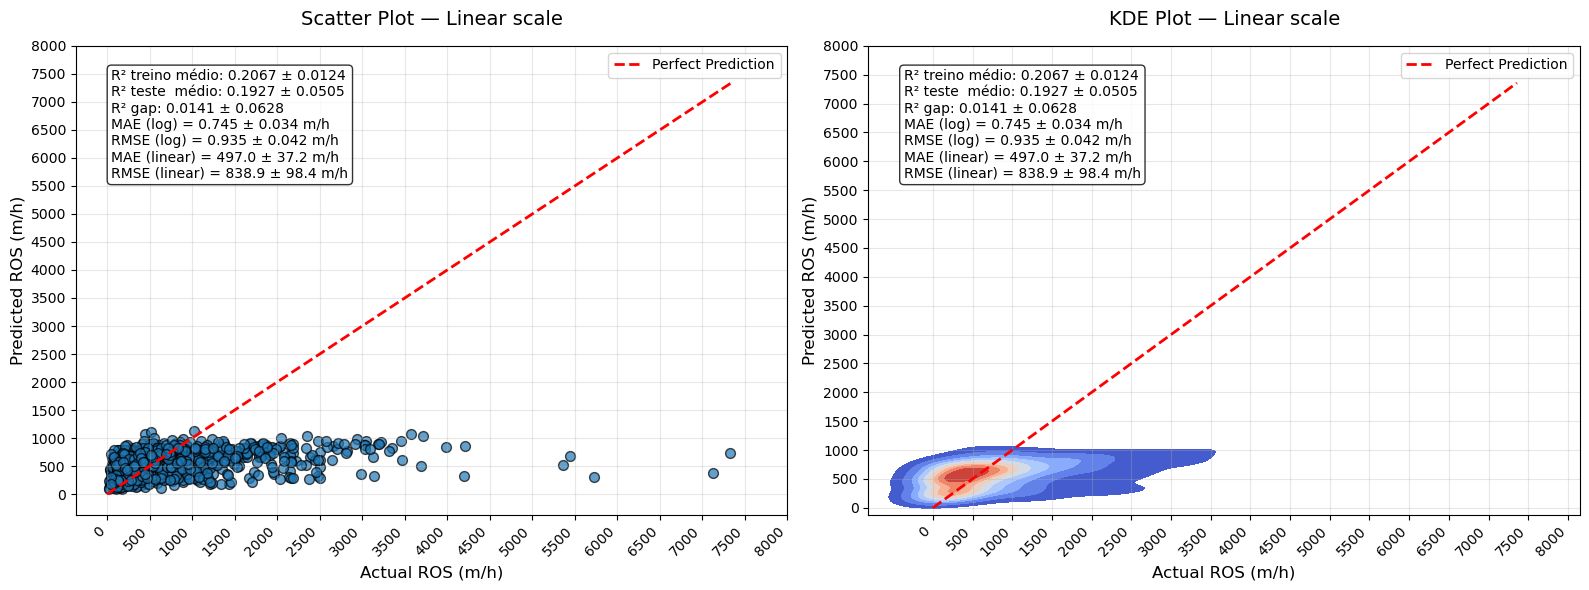

In [18]:
# =============================
# Scatter + 2D KDE com estilo parecido + caixa de texto
# =============================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

# -----------------------------
# Scatter plot (ax1)
# -----------------------------
sc1 = ax1.scatter(
    avg_actual_linear, avg_pred_linear,
    alpha=0.7, edgecolor='k', s=50
)

max_val = max(avg_actual_linear.max(), avg_pred_linear.max()) * 1.005
ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax1.set_title("Scatter Plot — Linear scale", fontsize=14, pad=15)
ax1.set_xlabel("Actual ROS (m/h)", fontsize=12)
ax1.set_ylabel("Predicted ROS (m/h)", fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# -----------------------------
# Caixa de texto (ax1)
# -----------------------------
ax1.text(
    0.05, 0.95,
    f"R² treino médio: {r2_train_cv:.4f} ± {r2_train_std:.4f}\n"
    f"R² teste  médio: {r2_test_cv:.4f} ± {r2_test_std:.4f}\n"
    f"R² gap: {r2_gap_cv:.4f} ± {r2_gap_std:.4f}\n"
    f'MAE (log) = {mae_cv_mean:.3f} ± {mae_cv_std:.3f} m/h\n'
    f'RMSE (log) = {rmse_cv_mean:.3f} ± {rmse_cv_std:.3f} m/h\n'
    f'MAE (linear) = {mae_linear_mean:.1f} ± {mae_linear_std:.1f} m/h\n'
    f'RMSE (linear) = {rmse_linear_mean:.1f} ± {rmse_linear_std:.1f} m/h',
    transform=ax1.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# -----------------------------
# 2D KDE plot (ax2)
# -----------------------------
sns.kdeplot(
    x=avg_actual_linear,
    y=avg_pred_linear,
    fill=True,
    cmap="coolwarm",
    thresh=0.04,
    ax=ax2
)
ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax2.set_title("KDE Plot — Linear scale", fontsize=14, pad=15)
ax2.set_xlabel("Actual ROS (m/h)", fontsize=12)
ax2.set_ylabel("Predicted ROS (m/h)", fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()

# -----------------------------
# Caixa de texto (ax2)
# -----------------------------
ax2.text(
    0.05, 0.95,
    f"R² treino médio: {r2_train_cv:.4f} ± {r2_train_std:.4f}\n"
    f"R² teste  médio: {r2_test_cv:.4f} ± {r2_test_std:.4f}\n"
    f"R² gap: {r2_gap_cv:.4f} ± {r2_gap_std:.4f}\n"
    f'MAE (log) = {mae_cv_mean:.3f} ± {mae_cv_std:.3f} m/h\n'
    f'RMSE (log) = {rmse_cv_mean:.3f} ± {rmse_cv_std:.3f} m/h\n'
    f'MAE (linear) = {mae_linear_mean:.1f} ± {mae_linear_std:.1f} m/h\n'
    f'RMSE (linear) = {rmse_linear_mean:.1f} ± {rmse_linear_std:.1f} m/h',
    transform=ax2.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# -----------------------------
# Ticks escalonados e layout
# -----------------------------
ticks = list(range(0, 8001, 500))
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax2.set_xticks(ticks)
ax2.set_yticks(ticks)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(ax1.get_yticklabels(), rotation=0, fontsize=10)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(ax2.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


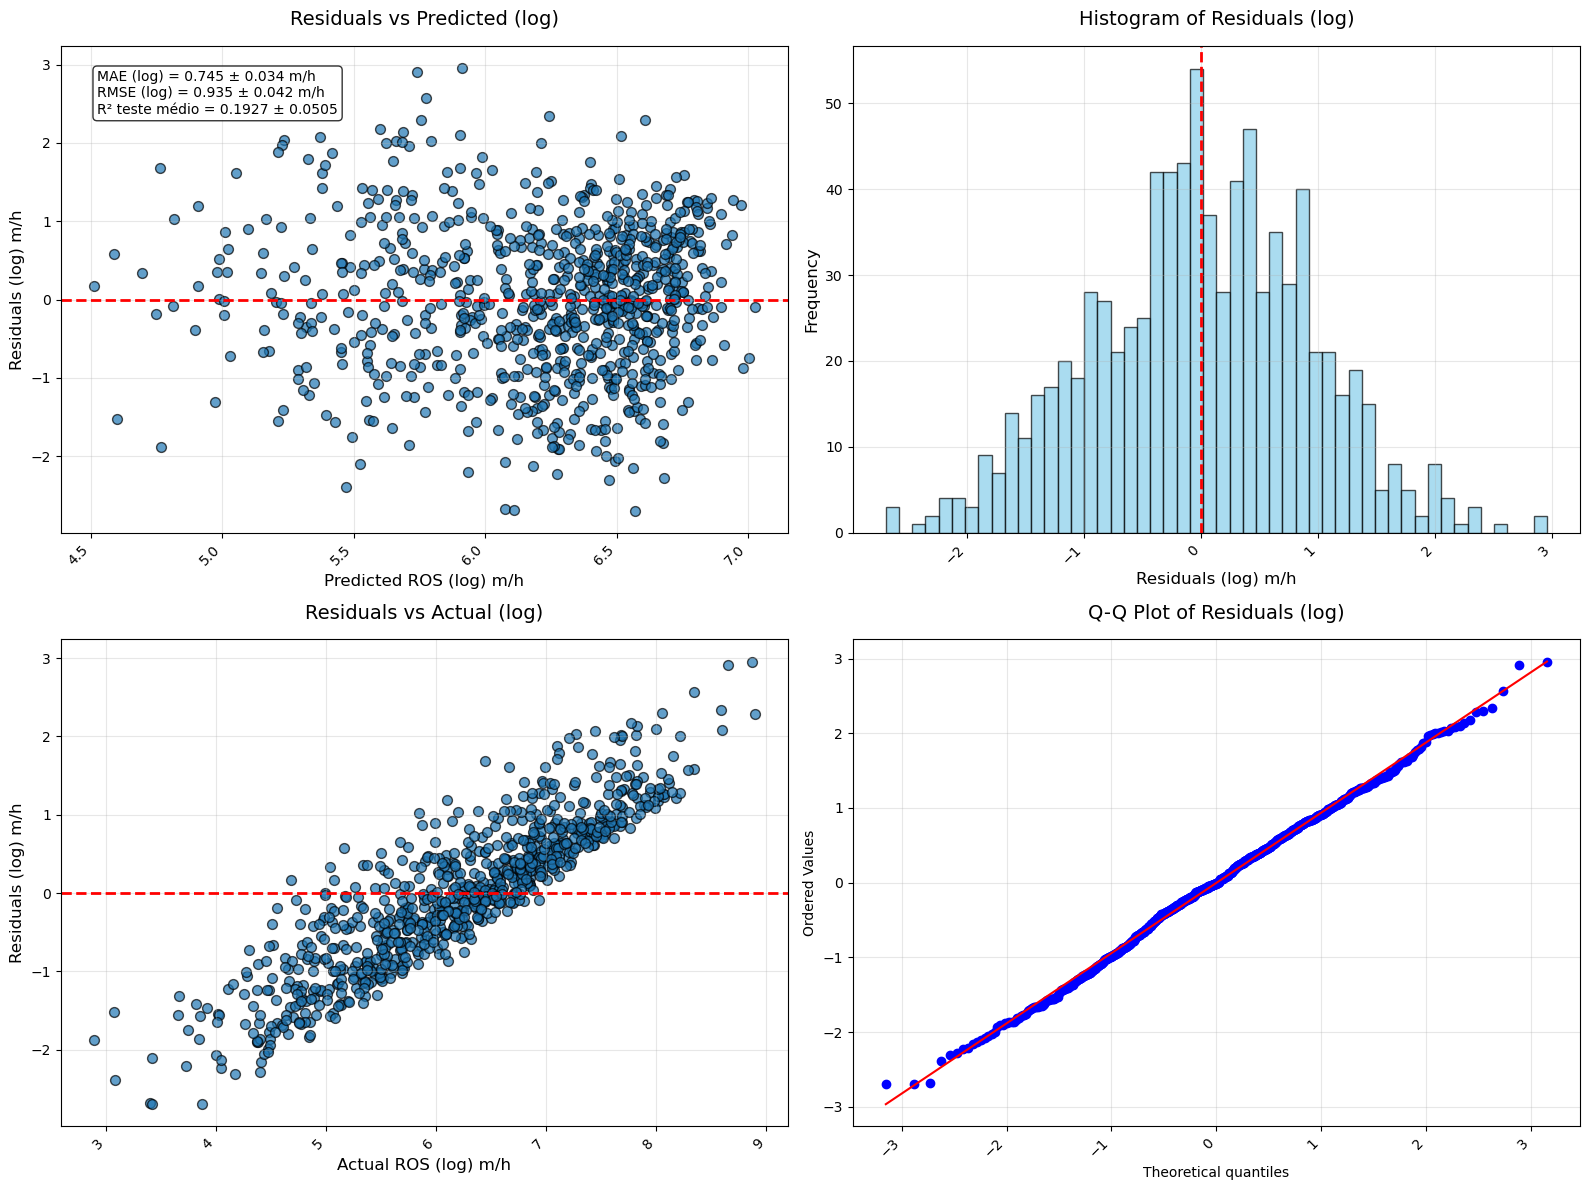

In [19]:
residuals_log = avg_actual_log - avg_pred_log

fig, axes = plt.subplots(2, 2, figsize=(16,12))

# -----------------------------
# Scatter: Residuals vs Predicted (log)
# -----------------------------
ax = axes[0,0]
sc = ax.scatter(avg_pred_log, residuals_log, alpha=0.7, edgecolor='k', s=50)
ax.axhline(0, color='r', ls='--', linewidth=2)
ax.set_title("Residuals vs Predicted (log)", fontsize=14, pad=15)
ax.set_xlabel("Predicted ROS (log) m/h", fontsize=12)
ax.set_ylabel("Residuals (log) m/h", fontsize=12)
ax.grid(True, alpha=0.3)

# Caixa de texto com métricas
ax.text(
    0.05, 0.95,
    f"MAE (log) = {mae_cv_mean:.3f} ± {mae_cv_std:.3f} m/h\n"
    f"RMSE (log) = {rmse_cv_mean:.3f} ± {rmse_cv_std:.3f} m/h\n"
    f"R² teste médio = {r2_test_cv:.4f} ± {r2_test_std:.4f}",
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# -----------------------------
# Histogram of Residuals
# -----------------------------
ax = axes[0,1]
ax.hist(residuals_log, bins=50, color='skyblue', edgecolor='k', alpha=0.7)
ax.axvline(0, color='r', ls='--', linewidth=2)
ax.set_title("Histogram of Residuals (log)", fontsize=14, pad=15)
ax.set_xlabel("Residuals (log) m/h", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.grid(True, alpha=0.3)

# -----------------------------
# Scatter: Residuals vs Actual (log)
# -----------------------------
ax = axes[1,0]
sc = ax.scatter(avg_actual_log, residuals_log, alpha=0.7, edgecolor='k', s=50)
ax.axhline(0, color='r', ls='--', linewidth=2)
ax.set_title("Residuals vs Actual (log)", fontsize=14, pad=15)
ax.set_xlabel("Actual ROS (log) m/h", fontsize=12)
ax.set_ylabel("Residuals (log) m/h", fontsize=12)
ax.grid(True, alpha=0.3)

# -----------------------------
# Q-Q Plot
# -----------------------------
ax = axes[1,1]
stats.probplot(residuals_log, dist="norm", plot=ax)
ax.set_title("Q-Q Plot of Residuals (log)", fontsize=14, pad=15)
ax.grid(True, alpha=0.3)

# -----------------------------
# Ticks e layout
# -----------------------------
for ax in axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


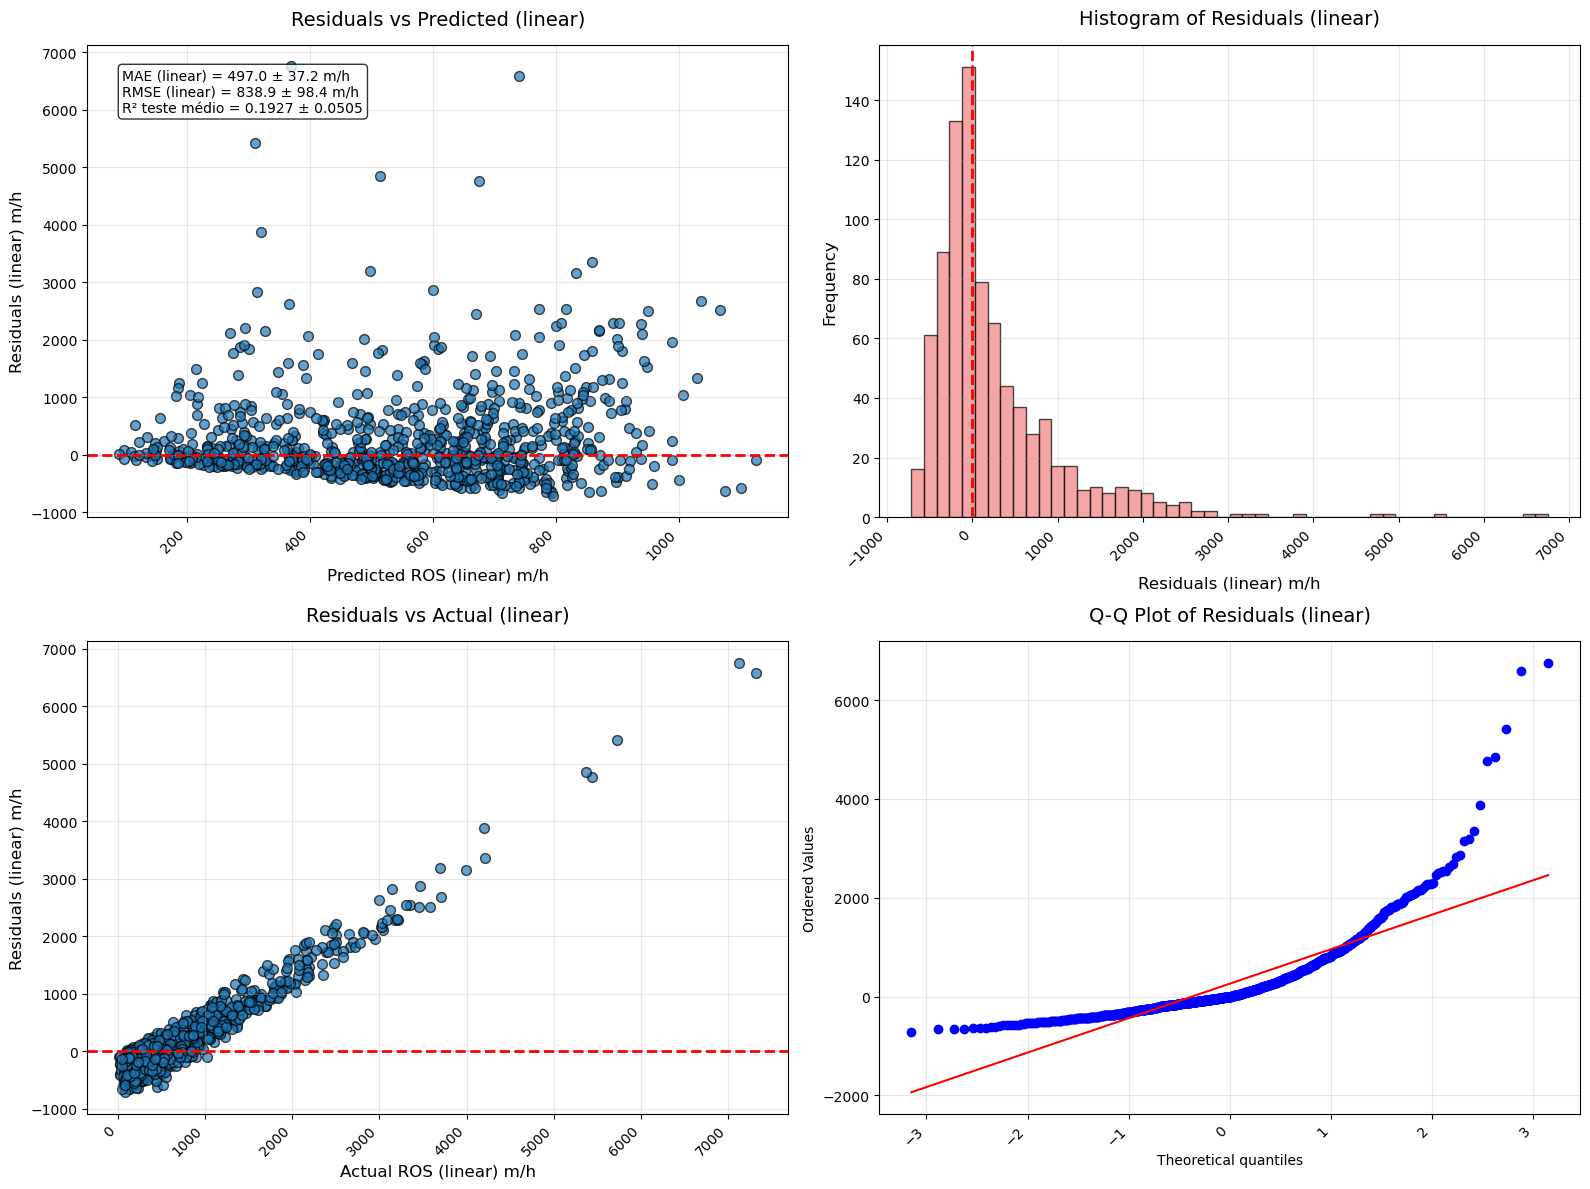

In [20]:
residuals_linear = avg_actual_linear - avg_pred_linear

fig, axes = plt.subplots(2, 2, figsize=(16,12))

# -----------------------------
# Scatter: Residuals vs Predicted (linear)
# -----------------------------
ax = axes[0,0]
sc = ax.scatter(avg_pred_linear, residuals_linear, alpha=0.7, edgecolor='k', s=50)
ax.axhline(0, color='r', ls='--', linewidth=2)
ax.set_title("Residuals vs Predicted (linear)", fontsize=14, pad=15)
ax.set_xlabel("Predicted ROS (linear) m/h", fontsize=12)
ax.set_ylabel("Residuals (linear) m/h", fontsize=12)
ax.grid(True, alpha=0.3)

# Caixa de texto com métricas
ax.text(
    0.05, 0.95,
    f"MAE (linear) = {mae_linear_mean:.1f} ± {mae_linear_std:.1f} m/h\n"
    f"RMSE (linear) = {rmse_linear_mean:.1f} ± {rmse_linear_std:.1f} m/h\n"
    f"R² teste médio = {r2_test_cv:.4f} ± {r2_test_std:.4f}",
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# -----------------------------
# Histogram of Residuals
# -----------------------------
ax = axes[0,1]
ax.hist(residuals_linear, bins=50, color='lightcoral', edgecolor='k', alpha=0.7)
ax.axvline(0, color='r', ls='--', linewidth=2)
ax.set_title("Histogram of Residuals (linear)", fontsize=14, pad=15)
ax.set_xlabel("Residuals (linear) m/h", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.grid(True, alpha=0.3)

# -----------------------------
# Scatter: Residuals vs Actual (linear)
# -----------------------------
ax = axes[1,0]
sc = ax.scatter(avg_actual_linear, residuals_linear, alpha=0.7, edgecolor='k', s=50)
ax.axhline(0, color='r', ls='--', linewidth=2)
ax.set_title("Residuals vs Actual (linear)", fontsize=14, pad=15)
ax.set_xlabel("Actual ROS (linear) m/h", fontsize=12)
ax.set_ylabel("Residuals (linear) m/h", fontsize=12)
ax.grid(True, alpha=0.3)

# -----------------------------
# Q-Q Plot
# -----------------------------
ax = axes[1,1]
stats.probplot(residuals_linear, dist="norm", plot=ax)
ax.set_title("Q-Q Plot of Residuals (linear)", fontsize=14, pad=15)
ax.grid(True, alpha=0.3)

# -----------------------------
# Ticks e layout
# -----------------------------
for ax in axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()
